# Estimating population of the NY state

# _Posterior analysis_

In [75]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [76]:
unit = 10000
mean = 0
vari = 1
prior = 2
post = 3

## Loading the posteriors

In [77]:
# We want to keep notebooks self-contained, so just put the ess estimator inline.
import scipy.fft

def ess(samples):
    """effective sample size"""    
    coeff = scipy.fft.fft(samples-samples.mean(), 2**int(numpy.floor(numpy.log2(len(samples)))))
    rhos = scipy.fft.ifft(coeff*numpy.conj(coeff))
    
    # compute effective sample size, stop when
    # the sum of two consecutive cross-correlations
    # becomes negative
    sum = 0.
    for i in range(1, len(samples)-1, 2):
        p = rhos[i] + rhos[i+1]
        if p < 0:
            break
        sum += p
    # cross-corellations are not normalized
    # and must be divided by cross-corellation at 0
    sum = numpy.real(sum/rhos[0])

    return len(samples) / (1. + sum)

sample 1:
	parameters: mean=1.686±0.509 sd=9.406±5.344 ess=3668
	predictive: mean=1.5716 quantiles[5%,50%,95%]=0.0156,0.3091,6.2005
sample 2:
	parameters: mean=2.402±0.910 sd=19.231±14.812 ess=2662
	predictive: mean=2.2583 quantiles[5%,50%,95%]=0.0128,0.3221,7.9954


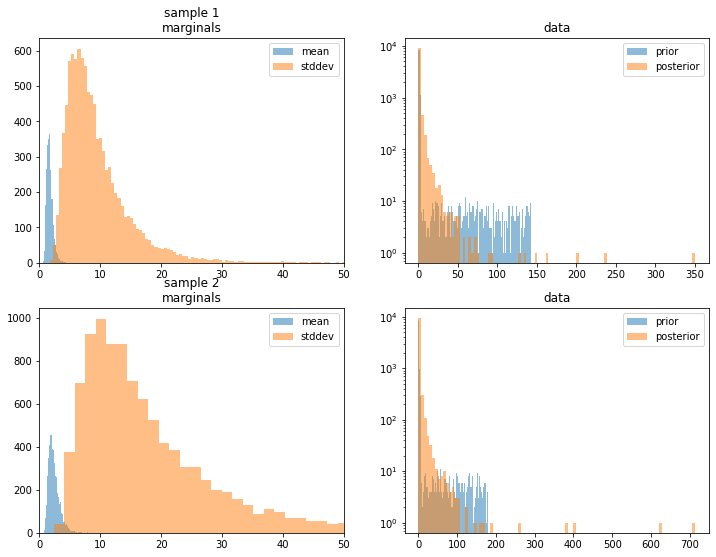

In [80]:
def posteriors():
    samples = ["1", "2"]
    fig, ax = plt.subplots(len(samples), 2, figsize=(12, 5))
    plt.subplots_adjust(top=1.5)
    posts = []
    for i, sample in enumerate(samples):
        d = numpy.genfromtxt(f"posterior-{sample}.csv", delimiter=",")
        d[:, [mean, vari]] = numpy.exp(d[:, [mean, vari]])

        ax[i][0].set_xlim(0, 50)
        ax[i][0].set_title(f"sample {sample}\nmarginals")
        ax[i][0].hist(d[:, mean], bins=100, alpha=0.5, label="mean")
        ax[i][0].hist(numpy.sqrt(d[:, vari]), bins=100, alpha=0.5, label="stddev")
        ax[i][0].legend()
        ax[i][1].set_yscale("log")
        ax[i][1].set_title("data")
        ax[i][1].hist(d[:,prior], bins=100, alpha=0.5, label="prior")
        ax[i][1].hist(d[:,post], bins=100, alpha=0.5, label="posterior")
        ax[i][1].legend()
        posts.append(d[:,post])
        print(("sample {}:\n"+ 
               "\tparameters: mean={:.3f}±{:.3f} sd={:.3f}±{:.3f} ess={:.0f}\n"+
               "\tpredictive: mean={:.4f} quantiles[5%,50%,95%]={:.4f},{:.4f},{:.4f}")
              .format(sample,
                      d[:,mean].mean(), d[:,mean].std(),
                      numpy.sqrt(d[:,vari]).mean(), numpy.sqrt(d[:,vari]).std(),
                      min(ess(d[:, mean]), ess(d[:, vari])),
                      d[:,post].mean(),
                      numpy.quantile(d[:,post], 0.05), numpy.median(d[:,post]), numpy.quantile(d[:,post], 0.95)))
    return posts
posts = posteriors()

## Estimating population total

Based on the predictive posterior, we can estimate the population total. We will draw 800 samples from the predictive posterior and use the distribution of the mean of 800 samples for the posterior interval of population total. For comparison, the best posterior intervals obtained and reported by Rubin using truncated power transformed random model are $[6 \times 10^6, 20 \times 10^6]$ for the first sample and $[10 \times 10^6, 34\times 10^6]$ for the second sample. These intervals are broader despite access to the whole data set.

sample 1:
	total: mean=1.26e+07 quantiles[2.5%,97.5%]=9.58e+06,1.73e+07
sample 2:
	total: mean=1.82e+07 quantiles[2.5%,97.5%]=1.28e+07,2.78e+07


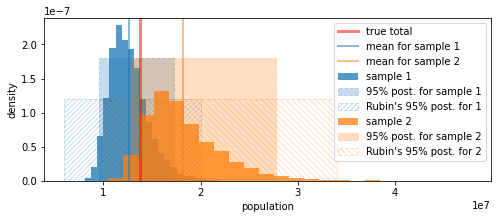

In [81]:
def total():
    N = 804   # municipalities in NY state
    K = 10000 # samples drawn
    TRUE_TOTAL = 13776663
    RUBIN = numpy.array([[6E6, 20E6], [10E6, 34E6]])
    cmap = cm.tab10
    plt.figure(figsize=(8, 3))
    plt.axvline(TRUE_TOTAL, color="red", linestyle="solid", alpha=0.5, lw=3, label="true total")
    plt.xlabel("population")
    plt.ylabel("density")
    for i, post in enumerate(posts):
        totals = []
        for j in range(K):
            totals.append(numpy.sum(numpy.random.choice(post, N)))
        totals = numpy.array(totals)*unit
        mean = numpy.mean(totals)
        low = numpy.quantile(totals, 0.025)
        high = numpy.quantile(totals, 0.975)
        plt.hist(totals, bins=25, alpha=0.75, label=f"sample {i+1}", density=True, color=cmap.colors[i])
        plt.axvspan(low, high, ymin=0, ymax=0.75, 
                    color=cmap.colors[i], lw=1, linestyle="dashed", alpha=0.25, 
                    label=f"95% post. for sample {i+1}")
        plt.axvspan(RUBIN[i, 0], RUBIN[i, 1], ymin=0, ymax=0.5,  
                    hatch='/////' if i==0 else '\\\\\\\\', edgecolor=cmap.colors[i], facecolor="none", lw=1, linestyle="dashed", alpha=0.25, 
                    label=f"Rubin's 95% post. for {i+1}")

        plt.axvline(mean, ymin=0, ymax=1, color=cmap.colors[i], lw=2, alpha=0.5, label=f"mean for sample {i+1}")
        print(f"sample {i+1}:\n"+ 
               f"\ttotal: mean={mean:.3g} quantiles[2.5%,97.5%]={low:.3g},{high:.3g}")
    plt.legend()
    plt.savefig("nypopu-estimate.pdf")
    plt.savefig("nypopu-estimate.svg")
total()